In [ ]:
import torch
print(torch.__version__)
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


2.7.1+cu118


In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)

True
0
1
NVIDIA GeForce RTX 3060 Laptop GPU
11.8


In [3]:
# 导入必要的库
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os
import random

# 设置随机种子以确保结果的可复现性
torch.manual_seed(42)  # 设置 PyTorch 的随机种子
np.random.seed(42)     # 设置 NumPy 的随机种子
random.seed(42)        # 设置 Python 内置随机模块的种子
print("Torch version:", torch.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)



# 检测并设置设备（CPU 或 GPU）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 打印设备信息
print("Using device:", device)

# 如果使用的是 GPU，打印 GPU 的详细信息
if device.type == "cuda":
    print("GPU Model:", torch.cuda.get_device_name(0))  # 打印 GPU 模型
    print("CUDA Version:", torch.version.cuda)          # 打印 CUDA 版本

Torch version: 2.7.1+cu118
Numpy version: 1.24.4
Pandas version: 1.5.3
Using device: cuda
GPU Model: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Version: 11.8


文件已成功解压到 jena_climate
成功加载 CSV 文件，数据行数: 420551

进行相关性分析...


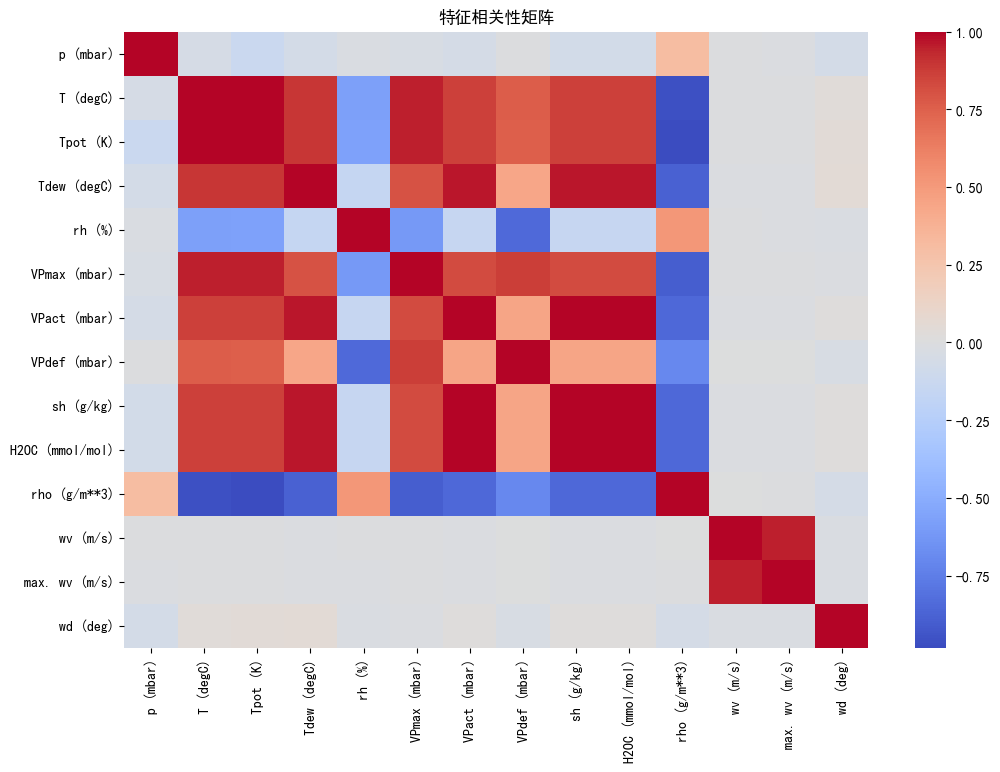

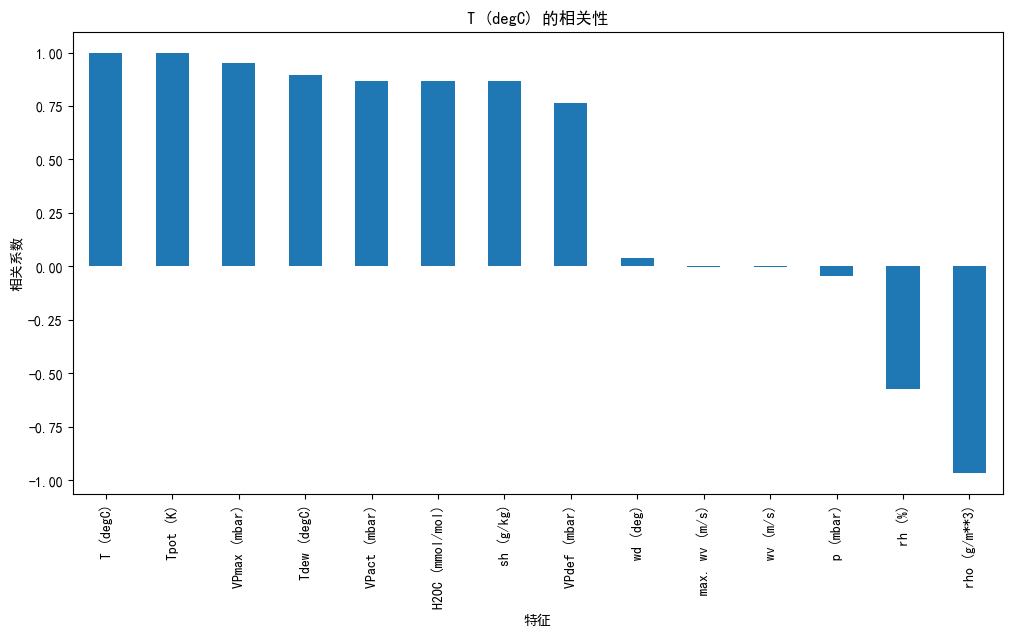


根据相关性自动选择的特征： ['T (degC)', 'Tpot (K)', 'VPmax (mbar)', 'Tdew (degC)', 'VPact (mbar)', 'H2OC (mmol/mol)', 'sh (g/kg)', 'VPdef (mbar)', 'rh (%)', 'rho (g/m**3)']
选择的特征列: ['T (degC)', 'Tpot (K)', 'VPmax (mbar)', 'Tdew (degC)', 'VPact (mbar)', 'H2OC (mmol/mol)', 'sh (g/kg)', 'VPdef (mbar)', 'rh (%)', 'rho (g/m**3)']
筛选后的数据已保存为 weather.csv
训练集样本输入 X 的维度: (336368, 72, 10)
训练集标签 y 的维度: (336368,)
验证集样本输入 X 的维度: (84111, 72, 10)
验证集标签 y 的维度: (84111,)
训练集样本输入 X 的维度: (336368, 72, 10)
训练集标签 y 的维度: (336368,)
验证集样本输入 X 的维度: (84111, 72, 10)
验证集标签 y 的维度: (84111,)
时间序列样本已保存为 X_train.npy, y_train.npy, X_val.npy, y_val.npy


In [4]:
"""
该脚本的主要功能是处理气象数据
包括解压数据文件、加载数据、预处理、归一化和构造时间序列样本。
具体步骤如下：
1. 解压 ZIP 文件，提取其中的 CSV 数据文件。
2. 加载 CSV 文件，读取气象数据。
3. 将日期时间列转换为 datetime 类型，便于后续处理。
4. 选择需要的气象特征列，并去除缺失值。
5. 将处理后的数据保存为新的 CSV 文件（可选）。
6. 对特征数据进行归一化处理，以便更好地训练模型。
7. 构造时间序列样本，将数据划分为输入序列 X 和目标标签 y。
8. 输出样本输入 X 和标签 y 的维度信息，确保数据格式正确。
"""
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']       # 设置中文字体为黑体（需要系统支持）
plt.rcParams['axes.unicode_minus'] = False         # 正确显示负号

def preprocess_weather_data(zip_path, extract_path, 
                            features=None, sequence_length=72, 
                            target_column="T (degC)", 
                            use_auto_feature_selection=False, 
                            train_ratio=0.8):
    """
    处理气象数据的主函数，包括解压、特征选择、归一化、时间序列样本生成等。
    
    参数:
        zip_path (str): ZIP 文件路径
        extract_path (str): 解压路径
        features (list): 指定特征列，默认使用温度、湿度、风速
        sequence_length (int): 时间序列长度，默认为72
        target_column (str): 要预测的目标列
        use_auto_feature_selection (bool): 是否启用自动相关性特征选择
        train_ratio (float): 训练集占总数据的比例，默认为0.8
    """
    import pandas as pd
    import numpy as np
    import zipfile
    import os
    import joblib
    import re
    import seaborn as sns
    from sklearn.preprocessing import MinMaxScaler

    # 安全文件名处理（用于保存 scaler）
    def safe_filename(name):
        return re.sub(r'[^a-zA-Z0-9_]', '_', name)

    # 默认特征
    if features is None:
        features = ["T (degC)", "rh (%)", "wv (m/s)"]

    # ========== 1. 解压 ZIP 文件 ==========
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"文件已成功解压到 {extract_path}")

    # ========== 2. 加载 CSV 文件 ==========
    csv_path = os.path.join(extract_path, "jena_climate_2009_2016.csv")
    df = pd.read_csv(csv_path)
    print(f"成功加载 CSV 文件，数据行数: {len(df)}")

    # ========== 3. 日期时间列转换 ==========
    df["Date Time"] = pd.to_datetime(df["Date Time"])

    # ========== 4. 自动相关性特征选择（可选） ==========
    if use_auto_feature_selection:
        print("\n进行相关性分析...")
        correlation_matrix = df.corr(numeric_only=True)

        correlations_with_target = correlation_matrix[target_column].sort_values(ascending=False)

        # 热力图展示
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
        plt.title("特征相关性矩阵")
        plt.show()

        # 柱状图展示与目标的相关性
        correlations_with_target.plot(kind='bar', figsize=(12, 6))
        plt.title(f"{target_column} 的相关性")
        plt.xlabel("特征")
        plt.ylabel("相关系数")
        plt.show()

        # 选择绝对相关性大于 0.5 的特征
        selected_features = correlations_with_target[abs(correlations_with_target) > 0.5].index.tolist()
        print("\n根据相关性自动选择的特征：", selected_features)

        # 避免重复包含目标列
        if target_column in selected_features:
            selected_features.remove(target_column)
        features = [target_column] + selected_features

    # ========== 5. 筛选指定特征列 ==========
    missing_features = [f for f in features if f not in df.columns]
    if missing_features:
        raise ValueError(f"以下特征列不存在于数据中: {missing_features}")

    # 提取并去除缺失值
    df_selected = df[["Date Time"] + features].dropna()
    print(f"选择的特征列: {features}")

    # ========== 6. 保存原始筛选数据 ==========
    df_selected.to_csv("weather.csv", index=False)
    print("筛选后的数据已保存为 weather.csv")

    # ========== 7. 每列分别归一化并拼接 ==========
    # 在划分训练集和验证集之前，先进行归一化操作
    train_size = int(train_ratio * len(df_selected))
    train_data = df_selected.iloc[:train_size]
    val_data = df_selected.iloc[train_size:]

    scalers = {}
    scaled_values_train = []
    scaled_values_val = []

    for col in features:
        scaler = MinMaxScaler()
        train_values = train_data[[col]].values
        val_values = val_data[[col]].values

        scaled_train = scaler.fit_transform(train_values)
        scaled_val = scaler.transform(val_values)

        scaled_values_train.append(scaled_train)
        scaled_values_val.append(scaled_val)

        scalers[col] = scaler
        joblib.dump(scaler, f"{safe_filename(col)}_scaler.pkl")

    # 拼接归一化后的数据
    data_scaled_train = np.concatenate(scaled_values_train, axis=1)
    data_scaled_val = np.concatenate(scaled_values_val, axis=1)

    df_scaled_train = pd.DataFrame(data_scaled_train, columns=features)
    df_scaled_val = pd.DataFrame(data_scaled_val, columns=features)

    df_scaled_train.insert(0, "Date Time", train_data["Date Time"].values)
    df_scaled_val.insert(0, "Date Time", val_data["Date Time"].values)

    # 保存归一化后的数据
    df_scaled_train.to_csv("scaled_weather_train.csv", index=False)
    df_scaled_val.to_csv("scaled_weather_val.csv", index=False)

    # ========== 8. 构造时间序列样本 ==========
    def create_sequences(data, sequence_length, target_column_index):
        """
        构造时间序列样本 (X, y)
        X: [samples, sequence_length, features]
        y: [samples]
        """
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:i + sequence_length])
            y.append(data[i + sequence_length][target_column_index])
        return np.array(X), np.array(y)
    # 获取目标列的索引
    target_column_index = features.index(target_column)

    # 构建时间序列样本
   # 构建时间序列样本
   # 拼接训练+验证数据（避免验证样本缺少前置序列）
    data_scaled_total = np.concatenate([data_scaled_train, data_scaled_val], axis=0)

# 记录切分点索引
    train_end_idx = len(data_scaled_train)
    # 防止验证样本构造越界（例如数据太小或 sequence_length 太大）
    if train_end_idx < sequence_length:
        raise ValueError("训练集太小，无法构造验证集样本，请减小 sequence_length 或使用更多数据。")

# 构建训练集样本（仅用训练部分）
    X_train, y_train = create_sequences(data_scaled_total[:train_end_idx], sequence_length, target_column_index)

# 构建验证集样本（起始点从 train_end_idx - sequence_length，确保每个序列都完整）
    X_val, y_val = create_sequences(data_scaled_total[train_end_idx - sequence_length:], sequence_length, target_column_index)

    #X_train, y_train = create_sequences(data_scaled_train, sequence_length, target_column_index)
    #X_val, y_val = create_sequences(data_scaled_val, sequence_length, target_column_index)# 输出样本维度并保存
    print("训练集样本输入 X 的维度:", X_train.shape)
    print("训练集标签 y 的维度:", y_train.shape)
    print("验证集样本输入 X 的维度:", X_val.shape)
    print("验证集标签 y 的维度:", y_val.shape)
    
    # ========== 9. 输出样本维度并保存 ==========
    print("训练集样本输入 X 的维度:", X_train.shape)
    print("训练集标签 y 的维度:", y_train.shape)
    print("验证集样本输入 X 的维度:", X_val.shape)
    print("验证集标签 y 的维度:", y_val.shape)

    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)
    np.save("X_val.npy", X_val)
    np.save("y_val.npy", y_val)
    print("时间序列样本已保存为 X_train.npy, y_train.npy, X_val.npy, y_val.npy")


# 调用示例
zip_path = "jena_climate.zip"
extract_path = "jena_climate"
preprocess_weather_data(zip_path, extract_path, use_auto_feature_selection=True)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

"""
该代码的功能是将气象数据封装为 PyTorch 数据集，并划分训练集和验证集。
主要步骤：
1. 定义一个继承自 Dataset 的 WeatherDataset 类，用于封装气象数据。
2. 创建数据集实例，并根据指定比例随机划分训练集和验证集。
3. 创建训练集和验证集的数据加载器 DataLoader 用于批量加载数据。
"""

# 定义一个天气数据集类，继承自 torch.utils.data.Dataset
class WeatherDataset(Dataset):
    """
    天气数据集类，用于封装气象数据。
    :param X: 特征数据
    :param y: 目标数据
    """
    def __init__(self, X, y):
        # 初始化函数，将输入的特征数据 X 和目标数据 y 转换为 torch 张量
        self.X = torch.tensor(X, dtype=torch.float32)  # 特征数据
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # 以确保输出形状为 (batch, 1)，方便回归模型处理

    def __len__(self):
        """
        返回数据集的长度，即样本数量。
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        根据索引 idx 获取数据集中的一个样本，返回特征和目标。
        :param idx: 样本索引
        :return: 特征和目标
        """
        return self.X[idx], self.y[idx]

def create_data_loaders(X, y, train_ratio=0.8, batch_size=32, shuffle_train=True, shuffle_val=False):
    """
    创建训练集和验证集的数据加载器。
    :param X: 特征数据
    :param y: 目标数据
    :param train_ratio: 训练集占总数据集的比例，默认为 0.8
    :param batch_size: 每个批次的样本数量，默认为 32
    :param shuffle_train: 是否打乱训练集，默认为 True
    :param shuffle_val: 是否打乱验证集，默认为 False
    :return: 训练集数据加载器和验证集数据加载器
    """
    # 检查输入数据是否为空
    if len(X) == 0 or len(y) == 0:
        raise ValueError("输入数据不能为空")
    # 创建数据集实例
    dataset = WeatherDataset(X, y)

    # 计算训练集和验证集的大小
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    # 随机划分数据集为训练集和验证集
    #train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataset = torch.utils.data.Subset(dataset, range(train_size))
    val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
    # 创建训练集和验证集的数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle_val)

    return train_loader, val_loader

# 示例：使用封装的函数创建数据加载器
# 假设 X 和 y 分别是特征数据和目标数据（需要提前定义）
# train_loader, val_loader = create_data_loaders(X, y)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# === 参数汇总 ===
# 输入特征维度: input_dim
# 隐藏层维度: hidden_dim (默认值: 64)
# 激素模块隐藏层维度: hormone_dim (默认值: 32)
# 最大序列长度: max_seq_len (默认值: 72)
# 池化策略: pooling (默认值: "mean"，可选值: "mean", "max", "last", "attention")
# 图注意力层多头注意力头数: n_heads (默认值: 8)
# Dropout 概率: dropout (默认值: 0.1)
# Transformer 编码器前馈网络维度: dim_feedforward (默认值: hidden_dim * 4)
# Transformer 编码器层数: num_layers (默认值: 1)

In [7]:
class GraphAttentionLayer(nn.Module):
    """
    图注意力层，用于模拟节点之间的间接影响。
    参数：
        in_dim (int): 输入特征的维度
        out_dim (int): 输出特征的维度
        n_heads (int): 多头注意力的头数，默认为 8
        dropout (float): Dropout 概率，默认为 0.1
    """
    def __init__(self, in_dim, out_dim, n_heads=8, dropout=0.1):
        super(GraphAttentionLayer, self).__init__()
        self.n_heads = n_heads  # 多头注意力的头数
        self.out_dim = out_dim  # 输出维度
        self.W = nn.Linear(in_dim, out_dim, bias=False)  # 线性变换，将输入维度映射到输出维度
        self.a = nn.Parameter(torch.empty(size=(2 * (out_dim // n_heads), 1)))  # 注意力参数矩阵
        nn.init.xavier_uniform_(self.a.data, gain=1.414)  # 使用 Xavier 初始化方法初始化注意力参数矩阵
        self.dropout = nn.Dropout(dropout)  # Dropout 层，用于防止过拟合
        
        # 如果输入维度和输出维度不一致，则使用残差投影层
        if in_dim != out_dim:
            self.residual_proj = nn.Linear(in_dim, out_dim)
        else:
            self.residual_proj = nn.Identity()

    def forward(self, x, adj_matrix=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状为 [B, T, D]
            adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
        返回：
            torch.Tensor: 输出特征，形状为 [B, T, out_dim]
        """
        B, T, D = x.size()  # 输入张量的形状，B 是批次大小，T 是节点数量，D 是输入特征维度
        h = self.W(x).view(B, T, self.n_heads, -1)  # 应用线性变换并调整形状
        h = h.permute(0, 2, 1, 3)  # 调整维度顺序，方便后续操作

        # 生成节点特征的重复版本，用于计算节点之间的注意力权重
        h_repeat = h.unsqueeze(3).repeat(1, 1, 1, T, 1)  # [B, n_heads, T, T, H//n_heads]
        h_repeat_T = h.unsqueeze(2).repeat(1, 1, T, 1, 1)  # [B, n_heads, T, T, H//n_heads]

        # 将重复的特征拼接起来，用于计算注意力权重
        combined = torch.cat([h_repeat, h_repeat_T], dim=-1)  # [B, n_heads, T, T, 2*H//n_heads]

        # 调整形状以方便矩阵乘法
        combined_reshape = combined.reshape(B * self.n_heads * T * T, -1)  # 展平为二维张量
        e = torch.matmul(combined_reshape, self.a).squeeze(-1)  # 计算注意力权重的原始值
        e = e.view(B, self.n_heads, T, T)  # 恢复原始形状
        '''
        # 应用 Softmax 函数，将注意力权重归一化为概率分布
        alpha = torch.softmax(e, dim=-1)  # [B, n_heads, T, T]
        alpha = self.dropout(alpha)  # 应用 Dropout
        '''        
        # 如果提供了动态邻接矩阵，则应用掩码
        if adj_matrix is not None:
            mask = (adj_matrix == 0).unsqueeze(1)  # [B, 1, T, T]
            e = e.masked_fill(mask, float('-inf'))  # 注意力分数先掩码
        alpha = torch.softmax(e, dim=-1)  # 应用 Softmax 函数
        alpha = self.dropout(alpha)  # 应用 Dropout
        # 使用注意力权重加权求和，得到每个节点的输出特征
        out = torch.matmul(alpha, h)  # [B, n_heads, T, H//n_heads]
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, self.out_dim)  # 调整形状并合并多头特征
        return out + self.residual_proj(x)  # 应用残差连接


In [8]:
# === 激素记忆模块 ===
class HormoneModule(nn.Module):
    """
    激素记忆模块，用于模拟激素对信息融合的调控作用。
    参数：
        input_dim (int): 输入特征的维度
        hidden_dim (int): GRU 隐藏层维度（记忆）
        output_dim (int): 控制信号输出的目标维度
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HormoneModule, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)  # GRU 层
        self.controller = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),  # 线性层
            nn.ReLU(),  # ReLU 激活函数
            nn.Linear(hidden_dim, 2 * output_dim)  # 输出层，生成 alpha 和 beta 控制信号
        )

    def forward(self, x, prev_state=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状为 [B, T, D]
            prev_state (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
        返回：
            alpha (torch.Tensor): 控制信号 alpha，形状为 [B, output_dim]
            beta (torch.Tensor): 控制信号 beta，形状为 [B, output_dim]
            hormone_state (torch.Tensor): 当前时刻的激素状态，形状为 [1, B, hidden_dim]
        """
        _, h = self.gru(x, prev_state)  # h: [1, B, hidden_dim]
        h = h.squeeze(0)  # [B, hidden_dim]
        gate = F.softplus(self.controller(h))  # 使用 Softplus 激活函数，使输出为正值

        alpha, beta = gate.chunk(2, dim=-1)  # 将输出分为 alpha 和 beta 两部分
        gate_sum = torch.clamp(alpha + beta, min=1e-8)  # 防止除零
        alpha = alpha / gate_sum  # 归一化 alpha
        beta = beta / gate_sum  # 归一化 beta
        return alpha, beta, h.unsqueeze(0)  # 返回控制信号和激素状态



In [ ]:
# === 时间编码器（多尺度 Transformer 层） ===
# class TemporalEncoder(nn.Module):
#     """
#     时间编码器，用于建模时间序列信息。
#     参数：
#         input_dim (int): 输入特征的维度
#         n_heads (int): 注意力头的数量，默认为 4
#         dropout (float): Dropout 概率，默认为 0.1
#         max_seq_len (int): 最大序列长度，默认为 512
#     """
#     def __init__(self, input_dim, n_heads=4, dropout=0.1, max_seq_len=512):
#         super(TemporalEncoder, self).__init__()
#         self.encoder = nn.TransformerEncoderLayer(
#             d_model=input_dim,  # 输入特征维度
#             nhead=n_heads,  # 注意力头数量
#             dim_feedforward=input_dim * 4,  # 前馈网络的维度
#             dropout=dropout,  # Dropout 概率
#             batch_first=True  # 批次维度在前
#         )
#         self.pos_enc = nn.Parameter(torch.randn(max_seq_len, input_dim))  # 位置编码参数
#         self.dropout = nn.Dropout(dropout)  # Dropout 层

#     def forward(self, x, mask=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
#         返回：
#             torch.Tensor: 编码后的特征，形状为 [B, T, D]
#         """
#         x = x + self.pos_enc[:x.size(1), :].unsqueeze(0)  # 添加位置编码
#         x = self.dropout(x)  # 应用 Dropout
#         return self.encoder(x, src_key_padding_mask=mask) + x  # 使用 Transformer 编码器处理输入，并添加残差连接



class TemporalEncoder(nn.Module):
    """
    时间编码器（多层 Transformer + 正弦位置编码）
    参数：
        input_dim (int): 输入特征维度
        n_heads (int): 多头注意力的头数
        num_layers (int): TransformerEncoder 层数
        dropout (float): Dropout 概率
        max_seq_len (int): 支持的最大序列长度（位置编码）
    """
    def __init__(self, input_dim, n_heads=4, num_layers=2, dropout=0.1, max_seq_len=512):
        super(TemporalEncoder, self).__init__()

        self.input_dim = input_dim
        self.max_seq_len = max_seq_len

        # 正弦位置编码（不可训练）
        self.pos_enc = self._generate_sinusoidal_encoding(max_seq_len, input_dim)  # [max_seq_len, input_dim]
        self.dropout = nn.Dropout(dropout)

        # 多层 Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=n_heads,
            dim_feedforward=input_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def _generate_sinusoidal_encoding(self, seq_len, dim):
        """
        生成正弦位置编码（不可训练）
        """
        pos = torch.arange(seq_len).unsqueeze(1)  # [seq_len, 1]
        i = torch.arange(dim).unsqueeze(0)  # [1, dim]
        angle_rates = 1 / torch.pow(10000, (2 * (i // 2)) / dim)
        angle_rads = pos * angle_rates  # [seq_len, dim]

        # 偶数维用 sin，奇数维用 cos
        pos_encoding = torch.zeros(seq_len, dim)
        pos_encoding[:, 0::2] = torch.sin(angle_rads[:, 0::2])
        pos_encoding[:, 1::2] = torch.cos(angle_rads[:, 1::2])

        return pos_encoding.unsqueeze(0)  # [1, seq_len, dim]

    def forward(self, x, mask=None):
        """
        参数：
            x: [B, T, D]
            mask: [B, T] 的 padding 掩码，True 表示需要 mask 的位置
        返回：
            [B, T, D]：Transformer 编码后的特征
        """
        seq_len = x.size(1)
        pos_encoding = self.pos_enc[:, :seq_len, :].to(x.device)  # [1, T, D]
        x = x + pos_encoding  # 添加位置编码
        x = self.dropout(x)

        # Transformer Encoder 编码
        out = self.encoder(x, src_key_padding_mask=mask) +x # [B, T, D]
        return out


In [10]:
# === 最终的脑启发式模型 ===
class BrainInspiredNetV2(nn.Module):
    """
    脑启发式模型，结合直接路径、间接路径、激素调控和时间编码。
    参数：
        input_dim (int): 输入特征的维度
        hidden_dim (int): 隐藏层的维度，默认为 64
        hormone_dim (int): 激素模块的隐藏层维度，默认为 32
        max_seq_len (int): 最大序列长度，默认为 72
        pooling (str): 序列汇聚策略，可选 'mean', 'max', 'last', 'attention'，默认为 'mean'
    """
    def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, max_seq_len=72, pooling="mean"):
        super(BrainInspiredNetV2, self).__init__()
        # ① 直接路径 MLP
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # 线性层
            nn.ReLU(),  # ReLU 激活函数
            nn.LayerNorm(hidden_dim),  # 层归一化
            nn.Dropout(0.2),  # Dropout 层
            nn.Linear(hidden_dim, hidden_dim)  # 线性层
        )

        # ② 间接路径 GAT
        self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)

        # ③ 激素调控模块
        self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)

        # ④ 时间编码器（Transformer）
        self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)

        # ⑤ 融合 + 输出
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)  # 融合层
        self.out_layer = nn.Linear(hidden_dim, 1)  # 输出层

        # 显式增加输出对齐层（用于 direct/indirect 路径）
        self.direct_proj = nn.Identity()  # 若 direct_out 已是 hidden_dim 可省略转换
        self.indirect_proj = nn.Linear(hidden_dim, hidden_dim)

        # 新增汇聚策略
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),  # 线性层
                nn.Tanh(),  # Tanh 激活函数
                nn.Linear(128, 1)  # 线性层
            )

    def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状为 [B, T, D]
            adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
            hormone_prev (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
            mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
        返回：
            torch.Tensor: 最终预测结果，形状为 [B]
            torch.Tensor: 当前时刻的激素状态，形状为 [1, B, hidden_dim]
        """
        B, T, D = x.shape

        # ① 路径输出
        direct_out = self.direct_mlp(x)  # [B, T, H]
        indirect_out = self.indirect_path(x, adj_matrix)  # [B, T, H]

        # ② 显式维度对齐
        direct_out = self.direct_proj(direct_out)  # [B, T, H]
        indirect_out = self.indirect_proj(indirect_out)  # [B, T, H]

        # ③ 激素调控融合
        alpha, beta, hormone_state = self.hormone_mod(x, hormone_prev)  # [B, H]
        alpha = alpha.unsqueeze(1)  # [B, 1, H]
        beta = beta.unsqueeze(1)  # [B, 1, H]
        fused = alpha * direct_out + beta * indirect_out  # [B, T, H]

        # ④ 时间编码器
        fused = self.fusion_dim(fused)  # [B, T, H]
        encoded = self.temporal_encoder(fused, mask=mask)  # [B, T, H]

        # ⑤ 最终输出（池化 + 回归）
        # 根据 pooling 选择不同的汇聚方式
        if self.pooling == "mean":
            pooled = encoded.mean(dim=1)  # 平均池化
        elif self.pooling == "max":
            pooled, _ = encoded.max(dim=1)  # 最大池化
        elif self.pooling == "last":
            pooled = encoded[:, -1, :]  # 取最后时间步
        elif self.pooling == "attention":
            att_weights = self.att_pool(encoded).squeeze(-1)  # [B, T]
            if mask is not None:
                att_weights = att_weights.masked_fill(mask, float('-inf'))
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)  # [B, T, 1]
            pooled = (encoded * att_weights).sum(dim=1)  # 加权池化
        else:
            raise ValueError(f"未知的池化类型: {self.pooling}")

        y = self.out_layer(pooled)  # [B, 1]
        return y.squeeze(-1), hormone_state  # [B], [1, B, H]



In [11]:
class BrainInspiredNetV2_NoHormone(nn.Module):
    """
    无激素模块的脑启发式模型（消融实验）
    结构包括直接路径、间接路径融合与时间编码器，支持多种池化策略。
    参数：
        input_dim (int): 输入特征维度
        hidden_dim (int): 隐藏层维度，默认64
        max_seq_len (int): 最大序列长度，默认72
        pooling (str): 池化策略，可选 'mean', 'max', 'last', 'attention'，默认 'mean'
    """
    def __init__(self, input_dim, hidden_dim=64, max_seq_len=72, pooling="mean"):
        super(BrainInspiredNetV2_NoHormone, self).__init__()

        # 直接路径：多层感知机
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # 间接路径：图注意力层
        self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)

        # 时间编码器：多层Transformer编码器，含正弦位置编码
        self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)

        # 融合映射层，用于融合后特征变换
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)

        # 输出层，回归预测
        self.out_layer = nn.Linear(hidden_dim, 1)

        # 池化策略选择
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )

    def forward(self, x, adj_matrix=None, mask=None):
        """
        前向传播函数。
        参数：
            x (torch.Tensor): 输入特征，形状 [B, T, D]
            adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状 [B, T, T]，默认为 None
            mask (torch.Tensor, optional): 掩码，形状 [B, T]，True表示该位置需要mask，默认为 None
        返回：
            torch.Tensor: 预测结果，形状 [B]
        """
        B, T, D = x.shape

        # 计算直接路径输出 [B, T, hidden_dim]
        direct_out = self.direct_mlp(x)

        # 计算间接路径输出（图注意力） [B, T, hidden_dim]
        indirect_out = self.indirect_path(x, adj_matrix)

        # 直接与间接路径特征融合
        fused = direct_out + indirect_out

        # 融合特征映射变换
        fused = self.fusion_dim(fused)

        # 时间编码器处理，融合后的序列特征编码 [B, T, hidden_dim]
        encoded = self.temporal_encoder(fused, mask=mask)

        # 序列池化汇聚
        if self.pooling == "mean":
            pooled = encoded.mean(dim=1)  # 平均池化
        elif self.pooling == "max":
            pooled, _ = encoded.max(dim=1)  # 最大池化
        elif self.pooling == "last":
            pooled = encoded[:, -1, :]  # 取最后时间步
        elif self.pooling == "attention":
            att_weights = self.att_pool(encoded).squeeze(-1)  # [B, T]
            if mask is not None:
                att_weights = att_weights.masked_fill(mask, float('-inf'))  # 屏蔽padding位置
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)  # 注意力权重归一化
            pooled = (encoded * att_weights).sum(dim=1)  # 加权求和池化
        else:
            raise ValueError(f"未知的池化类型: {self.pooling}")

        # 输出回归预测结果
        y = self.out_layer(pooled)  # [B, 1]
        return y.squeeze(-1)  # [B]


In [12]:
class BrainInspiredNetV2_NoIndirect(nn.Module):
    """
    消融实验模型：去掉间接路径（GAT），保留直接路径、激素调控和时间编码器。
    参数：
        input_dim (int): 输入特征维度
        hidden_dim (int): 隐藏层维度，默认64
        hormone_dim (int): 激素模块隐藏层维度，默认32
        max_seq_len (int): 最大序列长度，默认72
        pooling (str): 池化策略，可选 'mean', 'max', 'last', 'attention'，默认 'mean'
    """
    def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, max_seq_len=72, pooling="mean"):
        super(BrainInspiredNetV2_NoIndirect, self).__init__()
        # 直接路径 MLP，用于特征提取
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # 激素调控模块，模拟激素对信息融合的调控作用
        self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)
        # 时间编码器（多层 Transformer + 正弦位置编码）
        self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)
        # 融合层，将编码特征映射到输出维度
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)
        # 输出层，预测目标
        self.out_layer = nn.Linear(hidden_dim, 1)
        # 池化策略配置
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )

    def forward(self, x, hormone_prev=None, mask=None):
        """
        前向传播。
        参数：
            x (torch.Tensor): 输入特征，[B, T, D]
            hormone_prev (torch.Tensor, optional): 上一时刻激素状态，[1, B, hormone_dim]
            mask (torch.Tensor, optional): 序列掩码，[B, T]，True表示掩盖位置
        返回：
            y (torch.Tensor): 预测结果，[B]
            hormone_state (torch.Tensor): 当前时刻激素状态，[1, B, hormone_dim]
        """
        B, T, D = x.shape

        # 直接路径特征提取
        direct_out = self.direct_mlp(x)  # [B, T, hidden_dim]

        # 激素模块产生调控信号及当前激素状态
        _, _, hormone_state = self.hormone_mod(x, hormone_prev)  # hormone_state: [1, B, hormone_dim]

        # 时间编码
        encoded = self.temporal_encoder(direct_out, mask=mask)  # [B, T, hidden_dim]

        # 序列池化
        if self.pooling == "mean":
            pooled = encoded.mean(dim=1)
        elif self.pooling == "max":
            pooled, _ = encoded.max(dim=1)
        elif self.pooling == "last":
            pooled = encoded[:, -1, :]
        elif self.pooling == "attention":
            att_weights = self.att_pool(encoded).squeeze(-1)  # [B, T]
            if mask is not None:
                att_weights = att_weights.masked_fill(mask, float('-inf'))
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)  # [B, T, 1]
            pooled = (encoded * att_weights).sum(dim=1)
        else:
            raise ValueError(f"未知池化方式：{self.pooling}")

        # 预测输出
        y = self.out_layer(pooled)  # [B, 1]

        return y.squeeze(-1), hormone_state  # [B], [1, B, hormone_dim]


In [13]:
class BrainInspiredNetV2_NoTemporal(nn.Module):
    """
    脑启发式模型消融版本 —— 去除时间编码器模块
    结构包含直接路径 MLP，间接路径 GAT，激素调控模块和融合池化输出
    参数：
        input_dim (int): 输入特征维度
        hidden_dim (int): 隐藏层维度，默认64
        hormone_dim (int): 激素模块隐藏层维度，默认32
        pooling (str): 序列池化策略，支持 'mean', 'max', 'last', 'attention'，默认 'mean'
    """
    def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, pooling="mean"):
        super(BrainInspiredNetV2_NoTemporal, self).__init__()
        
        # 直接路径 MLP 模块
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )
        
        # 间接路径 图注意力网络（GAT）
        self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)
        
        # 激素调控模块
        self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)
        
        # 融合层，增强特征表达
        self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)
        
        # 输出层
        self.out_layer = nn.Linear(hidden_dim, 1)
        
        # 池化方式设置
        self.pooling = pooling
        if pooling == "attention":
            self.att_pool = nn.Sequential(
                nn.Linear(hidden_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 1)
            )

    def forward(self, x, adj_matrix=None, hormone_prev=None):
        """
        前向传播
        参数：
            x (torch.Tensor): 输入，形状 [B, T, D]
            adj_matrix (torch.Tensor, optional): 邻接矩阵，形状 [B, T, T]
            hormone_prev (torch.Tensor, optional): 之前的激素状态，形状 [1, B, hidden_dim]
        返回：
            y (torch.Tensor): 预测结果 [B]
            hormone_state (torch.Tensor): 当前激素状态 [1, B, hidden_dim]
        """
        B, T, D = x.shape
        
        direct_out = self.direct_mlp(x)             # 直接路径 [B, T, H]
        indirect_out = self.indirect_path(x, adj_matrix)  # 间接路径 [B, T, H]
        
        alpha, beta, hormone_state = self.hormone_mod(x, hormone_prev)  # alpha, beta: [B, H]
        alpha = alpha.unsqueeze(1)  # 扩展为 [B, 1, H]
        beta = beta.unsqueeze(1)
        
        fused = alpha * direct_out + beta * indirect_out  # 加权融合 [B, T, H]
        
        fused = self.fusion_dim(fused)  # 融合层线性变换
        
        # 池化
        if self.pooling == "mean":
            pooled = fused.mean(dim=1)
        elif self.pooling == "max":
            pooled, _ = fused.max(dim=1)
        elif self.pooling == "last":
            pooled = fused[:, -1, :]
        elif self.pooling == "attention":
            att_weights = self.att_pool(fused).squeeze(-1)  # [B, T]
            att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)
            pooled = (fused * att_weights).sum(dim=1)
        else:
            raise ValueError(f"未知池化类型: {self.pooling}")

        y = self.out_layer(pooled).squeeze(-1)  # [B]
        return y, hormone_state


In [14]:
class BrainInspiredNetV2_SimpleFC(nn.Module):
    """
    简化版脑启发式模型 — 仅含多层全连接网络（MLP）
    
    参数：
        input_dim (int): 输入特征维度
        hidden_dim (int): 隐藏层维度，默认64
        dropout (float): Dropout概率，默认0.2
        
    输入：
        x (torch.Tensor): 输入张量，形状为 [B, T, D] 或 [B, D]
            - 若为3维张量，则对时间维度T做平均池化
            
    输出：
        torch.Tensor: 预测结果，形状为 [B]
    """
    def __init__(self, input_dim, hidden_dim=64, dropout=0.2):
        super(BrainInspiredNetV2_SimpleFC, self).__init__()
        self.direct_mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)
        )
        self._init_weights()

    def _init_weights(self):
        """初始化线性层权重和偏置，采用Kaiming正态分布初始化"""
        for m in self.direct_mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        """
        前向传播
        
        参数：
            x (torch.Tensor): 输入张量，形状为 [B, T, D] 或 [B, D]
        
        返回：
            torch.Tensor: 模型输出，形状为 [B]
        """
        if x.dim() == 3:
            x = x.mean(dim=1)  # 对时间维度求平均，变为 [B, D]
        return self.direct_mlp(x).squeeze(-1)  # 输出形状为 [B]


In [15]:
# === 可视化模块 ===
def visualize_alpha_beta(alpha, beta, batch_idx=0, title="Alpha/Beta Weights", save_path=None):
    """
    可视化 alpha 和 beta 权重的变化。
    参数：
        alpha (torch.Tensor): alpha 权重，形状为 [B, T, H]
        beta (torch.Tensor): beta 权重，形状为 [B, T, H]
        batch_idx (int): 选择要可视化的批次，默认为 0
        title (str): 图表标题，默认为 "Alpha/Beta Weights"
    """
    B, T, H = alpha.shape
    alpha = alpha[batch_idx].detach().cpu().numpy()
    beta = beta[batch_idx].detach().cpu().numpy()

    plt.figure(figsize=(12, 6))
    for i in range(H):
        plt.subplot(H, 1, i + 1)
        plt.plot(alpha[:, i], label=f"Alpha {i+1}")
        plt.plot(beta[:, i], label=f"Beta {i+1}")
        plt.legend()
        plt.title(f"Weights for Head {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Weight Value")
    plt.suptitle(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
'''
# === 使用示例 ===
if __name__ == "__main__":
    # 示例输入数据
    B, T, D = 2, 10, 10  # 批次大小、时间步长、特征维度
    x = torch.randn(B, T, D)  # 示例输入
    adj_matrix = torch.randint(0, 2, (B, T, T)).float()  # 示例动态邻接矩阵

    # 初始化模型
    model = BrainInspiredNetV2(input_dim=D, hidden_dim=64, hormone_dim=32, max_seq_len=T, pooling="mean")

    # 前向传播
    y, hormone_state = model(x, adj_matrix=adj_matrix)

    # 可视化 alpha 和 beta 权重
    alpha, beta, _ = model.hormone_mod(x)
    visualize_alpha_beta(alpha, beta)
'''

'\n# === 使用示例 ===\nif __name__ == "__main__":\n    # 示例输入数据\n    B, T, D = 2, 10, 10  # 批次大小、时间步长、特征维度\n    x = torch.randn(B, T, D)  # 示例输入\n    adj_matrix = torch.randint(0, 2, (B, T, T)).float()  # 示例动态邻接矩阵\n\n    # 初始化模型\n    model = BrainInspiredNetV2(input_dim=D, hidden_dim=64, hormone_dim=32, max_seq_len=T, pooling="mean")\n\n    # 前向传播\n    y, hormone_state = model(x, adj_matrix=adj_matrix)\n\n    # 可视化 alpha 和 beta 权重\n    alpha, beta, _ = model.hormone_mod(x)\n    visualize_alpha_beta(alpha, beta)\n'

In [16]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # === 参数汇总 ===
# # 输入特征维度: input_dim
# # 隐藏层维度: hidden_dim (默认值: 64)
# # 激素模块隐藏层维度: hormone_dim (默认值: 32)
# # 最大序列长度: max_seq_len (默认值: 72)
# # 池化策略: pooling (默认值: "mean"，可选值: "mean", "max", "last", "attention")
# # 图注意力层多头注意力头数: n_heads (默认值: 8)
# # Dropout 概率: dropout (默认值: 0.1)
# # Transformer 编码器前馈网络维度: dim_feedforward (默认值: hidden_dim * 4)
# # Transformer 编码器层数: num_layers (默认值: 1)

# # === 间接影响的图注意力层 ===
# class GraphAttentionLayer(nn.Module):
#     """
#     图注意力层，用于模拟节点之间的间接影响。
#     参数：
#         in_dim (int): 输入特征的维度
#         out_dim (int): 输出特征的维度
#         n_heads (int): 多头注意力的头数，默认为 8
#         dropout (float): Dropout 概率，默认为 0.1
#     """
#     def __init__(self, in_dim, out_dim, n_heads=8, dropout=0.1):
#         super(GraphAttentionLayer, self).__init__()
#         self.n_heads = n_heads  # 多头注意力的头数
#         self.out_dim = out_dim  # 输出维度
#         self.W = nn.Linear(in_dim, out_dim, bias=False)  # 线性变换，将输入维度映射到输出维度
#         self.a = nn.Parameter(torch.empty(size=(2 * (out_dim // n_heads), 1)))  # 注意力参数矩阵
#         nn.init.xavier_uniform_(self.a.data, gain=1.414)  # 使用 Xavier 初始化方法初始化注意力参数矩阵
#         self.dropout = nn.Dropout(dropout)  # Dropout 层，用于防止过拟合
        
#         # 如果输入维度和输出维度不一致，则使用残差投影层
#         if in_dim != out_dim:
#             self.residual_proj = nn.Linear(in_dim, out_dim)
#         else:
#             self.residual_proj = nn.Identity()

#     def forward(self, x, adj_matrix=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
#         返回：
#             torch.Tensor: 输出特征，形状为 [B, T, out_dim]
#         """
#         B, T, D = x.size()  # 输入张量的形状，B 是批次大小，T 是节点数量，D 是输入特征维度
#         h = self.W(x).view(B, T, self.n_heads, -1)  # 应用线性变换并调整形状
#         h = h.permute(0, 2, 1, 3)  # 调整维度顺序，方便后续操作

#         # 生成节点特征的重复版本，用于计算节点之间的注意力权重
#         h_repeat = h.unsqueeze(3).repeat(1, 1, 1, T, 1)  # [B, n_heads, T, T, H//n_heads]
#         h_repeat_T = h.unsqueeze(2).repeat(1, 1, T, 1, 1)  # [B, n_heads, T, T, H//n_heads]

#         # 将重复的特征拼接起来，用于计算注意力权重
#         combined = torch.cat([h_repeat, h_repeat_T], dim=-1)  # [B, n_heads, T, T, 2*H//n_heads]

#         # 调整形状以方便矩阵乘法
#         combined_reshape = combined.reshape(B * self.n_heads * T * T, -1)  # 展平为二维张量
#         e = torch.matmul(combined_reshape, self.a).squeeze(-1)  # 计算注意力权重的原始值
#         e = e.view(B, self.n_heads, T, T)  # 恢复原始形状

#         # 应用 Softmax 函数，将注意力权重归一化为概率分布
#         alpha = torch.softmax(e, dim=-1)  # [B, n_heads, T, T]
#         alpha = self.dropout(alpha)  # 应用 Dropout
        
#         # 如果提供了动态邻接矩阵，则应用掩码
#         if adj_matrix is not None:
#             mask = (adj_matrix == 0).unsqueeze(1)  # [B, 1, T, T]
#             e = e.masked_fill(mask, float('-inf'))  # 注意力分数先掩码
#         alpha = torch.softmax(e, dim=-1)  # 应用 Softmax 函数
#         alpha = self.dropout(alpha)  # 应用 Dropout
#         # 使用注意力权重加权求和，得到每个节点的输出特征
#         out = torch.matmul(alpha, h)  # [B, n_heads, T, H//n_heads]
#         out = out.permute(0, 2, 1, 3).contiguous().view(B, T, self.out_dim)  # 调整形状并合并多头特征
#         return out + self.residual_proj(x)  # 应用残差连接


# # === 激素记忆模块 ===
# class HormoneModule(nn.Module):
#     """
#     激素记忆模块，用于模拟激素对信息融合的调控作用。
#     参数：
#         input_dim (int): 输入特征的维度
#         hidden_dim (int): GRU 隐藏层维度（记忆）
#         output_dim (int): 控制信号输出的目标维度
#     """
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(HormoneModule, self).__init__()
#         self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)  # GRU 层
#         self.controller = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),  # 线性层
#             nn.ReLU(),  # ReLU 激活函数
#             nn.Linear(hidden_dim, 2 * output_dim)  # 输出层，生成 alpha 和 beta 控制信号
#         )

#     def forward(self, x, prev_state=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             prev_state (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
#         返回：
#             alpha (torch.Tensor): 控制信号 alpha，形状为 [B, output_dim]
#             beta (torch.Tensor): 控制信号 beta，形状为 [B, output_dim]
#             hormone_state (torch.Tensor): 当前时刻的激素状态，形状为 [1, B, hidden_dim]
#         """
#         _, h = self.gru(x, prev_state)  # h: [1, B, hidden_dim]
#         h = h.squeeze(0)  # [B, hidden_dim]
#         gate = F.softplus(self.controller(h))  # 使用 Softplus 激活函数，使输出为正值

#         alpha, beta = gate.chunk(2, dim=-1)  # 将输出分为 alpha 和 beta 两部分
#         gate_sum = torch.clamp(alpha + beta, min=1e-8)  # 防止除零
#         alpha = alpha / gate_sum  # 归一化 alpha
#         beta = beta / gate_sum  # 归一化 beta
#         return alpha, beta, h.unsqueeze(0)  # 返回控制信号和激素状态


# # === 时间编码器（多尺度 Transformer 层） ===
# class TemporalEncoder(nn.Module):
#     """
#     时间编码器，用于建模时间序列信息。
#     参数：
#         input_dim (int): 输入特征的维度
#         n_heads (int): 注意力头的数量，默认为 4
#         dropout (float): Dropout 概率，默认为 0.1
#         max_seq_len (int): 最大序列长度，默认为 512
#     """
#     def __init__(self, input_dim, n_heads=4, dropout=0.1, max_seq_len=512):
#         super(TemporalEncoder, self).__init__()
#         self.encoder = nn.TransformerEncoderLayer(
#             d_model=input_dim,  # 输入特征维度
#             nhead=n_heads,  # 注意力头数量
#             dim_feedforward=input_dim * 4,  # 前馈网络的维度
#             dropout=dropout,  # Dropout 概率
#             batch_first=True  # 批次维度在前
#         )
#         self.pos_enc = nn.Parameter(torch.randn(max_seq_len, input_dim))  # 位置编码参数
#         self.dropout = nn.Dropout(dropout)  # Dropout 层

#     def forward(self, x, mask=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
#         返回：
#             torch.Tensor: 编码后的特征，形状为 [B, T, D]
#         """
#         x = x + self.pos_enc[:x.size(1), :].unsqueeze(0)  # 添加位置编码
#         x = self.dropout(x)  # 应用 Dropout
#         return self.encoder(x, src_key_padding_mask=mask) + x  # 使用 Transformer 编码器处理输入，并添加残差连接


# # === 最终的脑启发式模型 ===
# class BrainInspiredNetV2(nn.Module):
#     """
#     脑启发式模型，结合直接路径、间接路径、激素调控和时间编码。
#     参数：
#         input_dim (int): 输入特征的维度
#         hidden_dim (int): 隐藏层的维度，默认为 64
#         hormone_dim (int): 激素模块的隐藏层维度，默认为 32
#         max_seq_len (int): 最大序列长度，默认为 72
#         pooling (str): 序列汇聚策略，可选 'mean', 'max', 'last', 'attention'，默认为 'mean'
#     """
#     def __init__(self, input_dim, hidden_dim=64, hormone_dim=32, max_seq_len=72, pooling="mean"):
#         super(BrainInspiredNetV2, self).__init__()
#         # ① 直接路径 MLP
#         self.direct_mlp = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),  # 线性层
#             nn.ReLU(),  # ReLU 激活函数
#             nn.LayerNorm(hidden_dim),  # 层归一化
#             nn.Dropout(0.2),  # Dropout 层
#             nn.Linear(hidden_dim, hidden_dim)  # 线性层
#         )

#         # ② 间接路径 GAT
#         self.indirect_path = GraphAttentionLayer(input_dim, hidden_dim, n_heads=8)

#         # ③ 激素调控模块
#         self.hormone_mod = HormoneModule(input_dim, hormone_dim, hidden_dim)

#         # ④ 时间编码器（Transformer）
#         self.temporal_encoder = TemporalEncoder(hidden_dim, max_seq_len=max_seq_len)

#         # ⑤ 融合 + 输出
#         self.fusion_dim = nn.Linear(hidden_dim, hidden_dim)  # 融合层
#         self.out_layer = nn.Linear(hidden_dim, 1)  # 输出层

#         # 显式增加输出对齐层（用于 direct/indirect 路径）
#         self.direct_proj = nn.Identity()  # 若 direct_out 已是 hidden_dim 可省略转换
#         self.indirect_proj = nn.Linear(hidden_dim, hidden_dim)

#         # 新增汇聚策略
#         self.pooling = pooling
#         if pooling == "attention":
#             self.att_pool = nn.Sequential(
#                 nn.Linear(hidden_dim, 128),  # 线性层
#                 nn.Tanh(),  # Tanh 激活函数
#                 nn.Linear(128, 1)  # 线性层
#             )

#     def forward(self, x, adj_matrix=None, hormone_prev=None, mask=None):
#         """
#         前向传播函数。
#         参数：
#             x (torch.Tensor): 输入特征，形状为 [B, T, D]
#             adj_matrix (torch.Tensor, optional): 动态邻接矩阵，形状为 [B, T, T]，默认为 None
#             hormone_prev (torch.Tensor, optional): 上一时刻的激素状态，形状为 [1, B, hidden_dim]，默认为 None
#             mask (torch.Tensor, optional): 掩码，用于处理不同长度的序列，默认为 None
#         返回：
#             torch.Tensor: 最终预测结果，形状为 [B]
#             torch.Tensor: 当前时刻的激素状态，形状为 [1, B, hidden_dim]
#         """
#         B, T, D = x.shape

#         # ① 路径输出
#         direct_out = self.direct_mlp(x)  # [B, T, H]
#         indirect_out = self.indirect_path(x, adj_matrix)  # [B, T, H]

#         # ② 显式维度对齐
#         direct_out = self.direct_proj(direct_out)  # [B, T, H]
#         indirect_out = self.indirect_proj(indirect_out)  # [B, T, H]

#         # ③ 激素调控融合
#         alpha, beta, hormone_state = self.hormone_mod(x, hormone_prev)  # [B, H]
#         alpha = alpha.unsqueeze(1)  # [B, 1, H]
#         beta = beta.unsqueeze(1)  # [B, 1, H]
#         fused = alpha * direct_out + beta * indirect_out  # [B, T, H]

#         # ④ 时间编码器
#         fused = self.fusion_dim(fused)  # [B, T, H]
#         encoded = self.temporal_encoder(fused, mask=mask)  # [B, T, H]

#         # ⑤ 最终输出（池化 + 回归）
#         # 根据 pooling 选择不同的汇聚方式
#         if self.pooling == "mean":
#             pooled = encoded.mean(dim=1)  # 平均池化
#         elif self.pooling == "max":
#             pooled, _ = encoded.max(dim=1)  # 最大池化
#         elif self.pooling == "last":
#             pooled = encoded[:, -1, :]  # 取最后时间步
#         elif self.pooling == "attention":
#             att_weights = self.att_pool(encoded).squeeze(-1)  # [B, T]
#             if mask is not None:
#                 att_weights = att_weights.masked_fill(mask, float('-inf'))
#             att_weights = torch.softmax(att_weights, dim=1).unsqueeze(-1)  # [B, T, 1]
#             pooled = (encoded * att_weights).sum(dim=1)  # 加权池化
#         else:
#             raise ValueError(f"未知的池化类型: {self.pooling}")

#         y = self.out_layer(pooled)  # [B, 1]
#         return y.squeeze(-1), hormone_state  # [B], [1, B, H]

# # === 可视化模块 ===
# def visualize_alpha_beta(alpha, beta, batch_idx=0, title="Alpha/Beta Weights", save_path=None):
#     """
#     可视化 alpha 和 beta 权重的变化。
#     参数：
#         alpha (torch.Tensor): alpha 权重，形状为 [B, T, H]
#         beta (torch.Tensor): beta 权重，形状为 [B, T, H]
#         batch_idx (int): 选择要可视化的批次，默认为 0
#         title (str): 图表标题，默认为 "Alpha/Beta Weights"
#     """
#     B, T, H = alpha.shape
#     alpha = alpha[batch_idx].detach().cpu().numpy()
#     beta = beta[batch_idx].detach().cpu().numpy()

#     plt.figure(figsize=(12, 6))
#     for i in range(H):
#         plt.subplot(H, 1, i + 1)
#         plt.plot(alpha[:, i], label=f"Alpha {i+1}")
#         plt.plot(beta[:, i], label=f"Beta {i+1}")
#         plt.legend()
#         plt.title(f"Weights for Head {i+1}")
#         plt.xlabel("Time Step")
#         plt.ylabel("Weight Value")
#     plt.suptitle(title)
#     if save_path is not None:
#         plt.savefig(save_path)
#     plt.show()
# '''
# # === 使用示例 ===
# if __name__ == "__main__":
#     # 示例输入数据
#     B, T, D = 2, 10, 10  # 批次大小、时间步长、特征维度
#     x = torch.randn(B, T, D)  # 示例输入
#     adj_matrix = torch.randint(0, 2, (B, T, T)).float()  # 示例动态邻接矩阵

#     # 初始化模型
#     model = BrainInspiredNetV2(input_dim=D, hidden_dim=64, hormone_dim=32, max_seq_len=T, pooling="mean")

#     # 前向传播
#     y, hormone_state = model(x, adj_matrix=adj_matrix)

#     # 可视化 alpha 和 beta 权重
#     alpha, beta, _ = model.hormone_mod(x)
#     visualize_alpha_beta(alpha, beta)
# '''

In [17]:
# import logging
# import os
# from datetime import datetime

# def setup_logger(log_path=None, level=logging.INFO):
#     """
#     配置日志记录器。支持同时输出到控制台和文件（自动添加时间戳）。

#     参数:
#         log_path (str): 日志文件路径前缀（如 logs/train.log），将自动加时间戳。
#         level (int): 日志级别，默认为 logging.INFO。

#     返回:
#         logger (logging.Logger): 配置完成的 logger 对象。
#     """
#     logger = logging.getLogger()
    
#     # 防止重复初始化 handler
#     #if logger.hasHandlers():
#     #    return logger

#     logger = logging.getLogger(f"Logger_{log_path}_{datetime.now().timestamp()}")
#     logger.setLevel(level)

#     formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

#     # 控制台输出
#     console_handler = logging.StreamHandler()
#     console_handler.setLevel(level)
#     console_handler.setFormatter(formatter)
#     logger.addHandler(console_handler)

#     if log_path:
#         log_dir = os.path.dirname(log_path)
#         if log_dir and not os.path.exists(log_dir):
#             os.makedirs(log_dir)
#         timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#         log_path_with_timestamp = f"{os.path.splitext(log_path)[0]}_{timestamp}{os.path.splitext(log_path)[1]}"
#         file_handler = logging.FileHandler(log_path_with_timestamp)
#         file_handler.setLevel(level)
#         file_handler.setFormatter(formatter)
#         logger.addHandler(file_handler)
#         logger.info(f" Logging to file: {log_path_with_timestamp}")
#         logger.log_path = log_path_with_timestamp  # 可选：绑定属性用于后续访问

#     return logger


In [18]:
import torch
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
def evaluate_model(model, data_loader, criterion, device, use_mask=False):
    """
    评估模型性能。

    参数:
        model (torch.nn.Module): 模型。
        data_loader (torch.utils.data.DataLoader): 数据加载器。
        criterion (callable): 损失函数。
        device (str): 设备（"cpu" 或 "cuda"）。
        use_mask (bool): 是否使用 mask 处理缺失点。默认为 False。

    返回值:
        avg_loss (float): 平均损失。
        r2 (float or list of float): 决定系数（R²），如果是多目标则返回列表。
        mae (float or list of float): 平均绝对误差（MAE），如果是多目标则返回列表。
        rmse (float or list of float): 均方根误差（RMSE），如果是多目标则返回列表。
    """
    model.eval()
    loss_sum = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in data_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            pred = outputs[0] if isinstance(outputs, tuple) else outputs
            # 如果输出是 [batch_size, 1]，转为 [batch_size]
            if pred.dim() == 2 and pred.size(1) == 1:
                pred = pred.squeeze(1)
            if y_batch.dim() == 2 and y_batch.size(1) == 1:
                y_batch = y_batch.squeeze(1)
            if use_mask:
                mask = ~torch.isnan(y_batch)
                pred_masked = pred[mask]         # shape: [有效元素数]
                y_batch_masked = y_batch[mask]   # shape: [有效元素数]
            else:
                pred_masked = pred               # shape: [batch_size]
                y_batch_masked = y_batch         # shape: [batch_size]


            loss = criterion(pred_masked, y_batch_masked)
            loss_sum += loss.item()

            y_true.append(y_batch_masked.cpu().numpy())
            y_pred.append(pred_masked.cpu().numpy())

    avg_loss = loss_sum / len(data_loader)
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    if y_true.ndim == 1:
        y_true = y_true[:, None]
    if y_pred.ndim == 1:
        y_pred = y_pred[:, None]


    is_multi_target = y_true.shape[-1] > 1
    metrics = {"R2": [], "MAE": [], "RMSE": []}

    for i in range(y_true.shape[-1]):
        y_true_i = y_true[:, i]
        y_pred_i = y_pred[:, i]

        if len(y_true_i) == 0 or np.all(np.isnan(y_true_i)):
            metrics["R2"].append(np.nan)
            metrics["MAE"].append(np.nan)
            metrics["RMSE"].append(np.nan)
        else:
            try:
                metrics["R2"].append(r2_score(y_true_i, y_pred_i))
                metrics["MAE"].append(mean_absolute_error(y_true_i, y_pred_i))
                metrics["RMSE"].append(np.sqrt(mean_squared_error(y_true_i, y_pred_i)))
            except Exception as e:
                logger.warning(f"计算评估指标时出现异常：{e}")
                metrics["R2"].append(np.nan)
                metrics["MAE"].append(np.nan)
                metrics["RMSE"].append(np.nan)

    if not is_multi_target:
        metrics["R2"] = metrics["R2"][0]
        metrics["MAE"] = metrics["MAE"][0]
        metrics["RMSE"] = metrics["RMSE"][0]

    return avg_loss, metrics["R2"], metrics["MAE"], metrics["RMSE"]

In [19]:
import os
import time
import json
from datetime import datetime
import torch
import torch.optim as optim
from tqdm import tqdm
import logging



class Trainer:
    """
    封装模型训练和验证的完整流程。

    参数:
        model (torch.nn.Module): 要训练的模型。
        train_loader (torch.utils.data.DataLoader): 训练数据加载器。
        val_loader (torch.utils.data.DataLoader): 验证数据加载器。
        optimizer (torch.optim.Optimizer): 优化器。
        criterion (callable): 损失函数。
        device (str): 训练设备（"cpu" 或 "cuda"）。
        max_epochs (int): 最大训练轮数。默认为 100。
        patience (int): 早停机制的耐心值。默认为 10。
        lr_scheduler_patience (int): 学习率调度器的耐心值。默认为 3。
        lr_scheduler_factor (float): 学习率调度器的衰减因子。默认为 0.5。
        save_path (str): 模型保存路径。默认为 None。
        log_path (str): 日志文件路径。默认为 None。
        custom_callbacks (list): 自定义回调函数列表。默认为 None。
        use_mask (bool): 是否使用 mask 处理缺失点。默认为 False。
        save_state_dict (bool): 是否保存模型的 state_dict 而非完整模型对象。默认为 False。
    """
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device, 
                 max_epochs=100, patience=10, lr_scheduler_patience=3, 
                 lr_scheduler_factor=0.5, save_path=None, log_path=None, 
                 custom_callbacks=None, use_mask=False, save_state_dict=False):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.max_epochs = max_epochs
        self.patience = patience
        self.lr_scheduler_patience = lr_scheduler_patience
        self.lr_scheduler_factor = lr_scheduler_factor
        self.save_path = save_path
        self.log_path = log_path
        self.custom_callbacks = custom_callbacks if custom_callbacks else []
        self.use_mask = use_mask
        self.save_state_dict = save_state_dict

        # 配置日志记录器
        setup_logger(log_path)

        # 检查设备是否可用
        if device == "cuda" and not torch.cuda.is_available():
            logger.warning("CUDA不可用，切换到CPU")
            self.device = "cpu"
        self.device = torch.device(self.device)

        # 将模型移动到指定设备
        self.model.to(self.device)

    
    
    
    def train(self):
        """
        开始训练模型。

        返回值:
            dict: 包含训练过程中的损失、指标和最佳模型信息。
        """
        best_loss = float("inf")
        best_model_state = None
        best_epoch = 0
        train_losses, val_losses = [], []
        val_metrics = {"R2": [], "MAE": [], "RMSE": []}

        # 初始化学习率调度器
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, patience=self.lr_scheduler_patience, factor=self.lr_scheduler_factor
        )
        early_stop_counter = 0

        # 如果保存路径包含目录且目录不存在，则创建目录
        if self.save_path:
            dir_name = os.path.dirname(self.save_path)
            if dir_name and not os.path.exists(dir_name):
                os.makedirs(dir_name)

        total_start_time = time.time()
        for epoch in range(1, self.max_epochs + 1):
            epoch_start_time = time.time()
            self.model.train()
            train_loss_sum = 0.0

            if len(self.train_loader) == 0:
                logger.error("训练数据加载器为空")
                raise ValueError("训练数据加载器为空")

            # 遍历训练数据加载器中的每个批次
            for batch in tqdm(self.train_loader, desc=f"Epoch {epoch:03d} Training", leave=True):
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

                # 使用中间变量统一预测维度
                #pred_aligned = pred.view(-1, 1)  # 将 [batch_size] 转为 [batch_size, 1]
                # 如果使用 mask 处理缺失值
                #if self.use_mask:
                #    mask = ~torch.isnan(y_batch)  # 创建 mask，标记非缺失值
                #    #y_batch_masked = y_batch[mask].reshape(-1, y_batch.size(-1))  # 使用 reshape 替代 view
                #    y_batch_masked = y_batch[mask].view(-1)
                #    pred_masked = pred[mask].view(-1)
                #else:
                #    #y_batch_masked = y_batch
                #    y_batch_masked = y_batch.view(-1)
                #    pred_masked = pred.view(-1)
                self.optimizer.zero_grad()
                
                
                # === 模型前向传播 ===
                outputs = self.model(x_batch)

                if isinstance(outputs, tuple):
                    
                    #print(f"[DEBUG] model output is tuple with length {len(outputs)}")
                    #print(f"[DEBUG] first element shape: {outputs[0].shape}")
                    pred = outputs[0]  # 原始模型输出
                else:
                    #print(f"[DEBUG] model output shape: {outputs.shape}")
                    pred = outputs
                    
                # 如果输出形状是 [batch_size, 1]，则 squeeze 成 [batch_size]
                if pred.dim() == 2 and pred.size(1) == 1:
                    pred = pred.squeeze(1)  # [32, 1] -> [32]
                # === 统一预测维度为 [batch_size, 1] ===
                #pred_aligned = pred_raw.view(-1, 1)
                
                # 标签也同样处理，确保是 [batch_size]
                if y_batch.dim() == 2 and y_batch.size(1) == 1:
                    y_batch = y_batch.squeeze(1)  # [32, 1] -> [32]
                # === Mask处理和标签统一维度 ===
                if self.use_mask:
                # 构造mask：标记非缺失值
                    mask = ~torch.isnan(y_batch)

                    # 将标签和预测都压缩到1D用于计算损失
                    pred_masked = pred[mask]
                    y_batch_masked = y_batch[mask]
                else:
                    #y_batch_masked = y_batch.view(-1)            # [batch_size]
                    #pred_masked = pred.view(-1)          # [batch_size]
                    #y_batch_masked = y_batch.squeeze(-1)  # 将 [batch_size, 1] -> [batch_size]
                    #pred_masked = pred.squeeze(-1)        # 同上，确保一致
                    y_batch_masked = y_batch.view(-1)  # shape: [batch_size, 1]
                    pred_masked = pred.view(-1)         # shape: [batch_size, 1]

                # === 损失计算 ===
                #print(f"[DEBUG] pred_masked shape: {pred_masked.shape}, y_batch_masked shape: {y_batch_masked.shape}")
                #print(f"pred_masked shape: {pred_masked.shape}, y_batch_masked shape: {y_batch_masked.shape}")

                loss = self.criterion(pred_masked, y_batch_masked)

                
                
                loss.backward()
                self.optimizer.step()

                train_loss_sum += loss.item()

            # 计算平均训练损失
            avg_train_loss = train_loss_sum / len(self.train_loader)
            train_losses.append(avg_train_loss)

            # 在验证集上评估模型
            avg_val_loss, r2, mae, rmse = evaluate_model(self.model, self.val_loader, self.criterion, self.device, self.use_mask)
            val_losses.append(avg_val_loss)
            val_metrics["R2"].append(r2)
            val_metrics["MAE"].append(mae)
            val_metrics["RMSE"].append(rmse)

            # 调整学习率
            scheduler.step(avg_val_loss)

            # 计算当前轮次的耗时
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            current_lr = self.optimizer.param_groups[0]['lr']
            # 记录日志
            log_data = {
                "epoch": epoch,
                "train_loss": float(avg_train_loss) if not isinstance(avg_train_loss, float) else avg_train_loss,  # 确保是原生 float
                "val_loss": float(avg_val_loss) if not isinstance(avg_val_loss, float) else avg_val_loss,  # 确保是原生 float
                "R2": float(r2) if not isinstance(r2, float) else r2,  # 确保是原生 float
                "MAE": float(mae) if not isinstance(mae, float) else mae,  # 确保是原生 float
                "RMSE": float(rmse) if not isinstance(rmse, float) else rmse,  # 确保是原生 float
                "lr": float(current_lr) if not isinstance(current_lr, float) else current_lr,  # 确保是原生 float
                "duration": float(epoch_duration) if not isinstance(epoch_duration, float) else epoch_duration,  # 确保是原生 float
                "samples_per_second": float(len(self.train_loader.dataset) / epoch_duration)  # 确保是原生 float
            }
            logger.info(json.dumps(log_data))


            # 如果当前轮次的验证损失是最佳的，则保存模型状态
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = self.model.state_dict()
                best_epoch = epoch
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                # 如果早停计数器达到耐心值，则触发早停机制
                if early_stop_counter >= self.patience:
                    logger.info(f"Early stopping triggered at epoch {epoch}")
                    break

            # 调用自定义回调函数
            if self.custom_callbacks:
                for callback in self.custom_callbacks:
                    try:
                        callback(self.model, epoch, avg_train_loss, avg_val_loss, self.optimizer, scheduler, best_loss, best_epoch)
                    except Exception as e:
                        logger.warning(f"Callback {callback} raised an exception: {e}")

        # 计算总训练时间
        total_end_time = time.time()
        total_duration = total_end_time - total_start_time
        logger.info(f"Training completed in {total_duration/60:.2f} minutes")

        # 加载最佳模型状态
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            # 保存模型
            if self.save_path:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                save_path_with_timestamp = f"{os.path.splitext(self.save_path)[0]}_{timestamp}{os.path.splitext(self.save_path)[1]}"
                if self.save_state_dict:
                    torch.save(best_model_state, save_path_with_timestamp)  # 保存 state_dict
                else:
                    torch.save(self.model, save_path_with_timestamp)  # 保存完整模型对象
                logger.info(f"Best model saved to {save_path_with_timestamp}")

        # 打印并记录最佳 epoch 的评估结果
        best_metrics = {
            "best_epoch": best_epoch,
            "best_loss": best_loss,
            "best_R2": val_metrics["R2"][best_epoch - 1],
            "best_MAE": val_metrics["MAE"][best_epoch - 1],
            "best_RMSE": val_metrics["RMSE"][best_epoch - 1]
        }
        logger.info(f"Best validation metrics at epoch {best_epoch}: {best_metrics}")

        return {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_metrics": val_metrics,
            "best_epoch": best_epoch,
            "best_loss": best_loss,
            "total_duration": total_duration
        }

In [20]:
import os
import torch
from datetime import datetime
import logging

logger = logging.getLogger(__name__)  # 建议模块级 logger


def save_intermediate_model(model, epoch, train_loss, val_loss, optimizer=None, scheduler=None, best_loss=None, best_epoch=None):
    # 函数实现
    """
    自定义回调函数：保存中间模型及优化器状态。

    参数:
        model (torch.nn.Module): 当前模型。
        epoch (int): 当前轮数。
        train_loss (float): 当前轮数的训练损失。
        val_loss (float): 当前轮数的验证损失。
        optimizer (torch.optim.Optimizer): 当前优化器（可选）。
        scheduler (torch.optim.lr_scheduler._LRScheduler): 当前调度器（可选）。
    
    返回:
        str: 保存的 checkpoint 路径。
    """
    dir_path = "models"
    os.makedirs(dir_path, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(dir_path, f"intermediate_epoch_{epoch}_{timestamp}.pth")

    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
    }

    if optimizer:
        checkpoint["optimizer_state_dict"] = optimizer.state_dict()
        lr = optimizer.param_groups[0].get("lr", None)
        if lr is not None:
            logger.info(f"[Epoch {epoch}] Learning rate: {lr}")

    if scheduler:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()
        patience = getattr(scheduler, "patience", "N/A")
        logger.info(f"[Epoch {epoch}] Scheduler patience: {patience}")

    torch.save(checkpoint, save_path)
    logger.info(f" Intermediate checkpoint saved to: {save_path}")
    return save_path


In [21]:

import numpy as np

# 加载处理后的数据
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")

print("X_train shape:", X_train.shape)  # 输出 X_train 的形状
print("y_train shape:", y_train.shape)  # 输出 y_train 的形状
print("X_val shape:", X_val.shape)      # 输出 X_val 的形状
print("y_val shape:", y_val.shape)      # 输出 y_val 的形状
# 加载处理后的数据

# 创建训练集和验证集的数据集实例
train_dataset = WeatherDataset(X_train, y_train)
val_dataset = WeatherDataset(X_val, y_val)

# 创建训练集和验证集的数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 验证数据加载器中的数据形状
for batch in train_loader:
    X_batch, y_batch = batch
    print("训练集批次 X 的形状:", X_batch.shape)
    print("训练集批次 y 的形状:", y_batch.shape)
    break

for batch in val_loader:
    X_batch, y_batch = batch
    print("验证集批次 X 的形状:", X_batch.shape)
    print("验证集批次 y 的形状:", y_batch.shape)
    break
from torch.utils.data import DataLoader, random_split


X_train shape: (336368, 72, 10)
y_train shape: (336368,)
X_val shape: (84111, 72, 10)
y_val shape: (84111,)
训练集批次 X 的形状: torch.Size([32, 72, 10])
训练集批次 y 的形状: torch.Size([32, 1])
验证集批次 X 的形状: torch.Size([32, 72, 10])
验证集批次 y 的形状: torch.Size([32, 1])


2025-06-07 01:25:24,021 - INFO - 【开始训练】模型：Full
Epoch 001 Training: 100%|██████████| 33637/33637 [11:57<00:00, 46.89it/s]
2025-06-07 01:38:10,506 - INFO - {"epoch": 1, "train_loss": 0.00024188292303088725, "val_loss": 5.320961773159662e-05, "R2": 0.9963990126211029, "MAE": 0.0054826620034873486, "RMSE": 0.0072947340086102486, "lr": 0.001, "duration": 763.789957523346, "samples_per_second": 352.31413734812674}
2025-06-07 01:38:10,507 - INFO - [Epoch 1] Learning rate: 0.001
2025-06-07 01:38:10,509 - INFO - [Epoch 1] Scheduler patience: 3
2025-06-07 01:38:10,535 - INFO -  Intermediate checkpoint saved to: models\intermediate_epoch_1_20250607_013810.pth
Epoch 002 Training: 100%|██████████| 33637/33637 [11:22<00:00, 49.29it/s]
2025-06-07 01:50:30,217 - INFO - {"epoch": 2, "train_loss": 3.726145799018788e-05, "val_loss": 5.0495245744440846e-05, "R2": 0.9965828088586112, "MAE": 0.006290299817919731, "RMSE": 0.007106132339686155, "lr": 0.001, "duration": 739.6814832687378, "samples_per_second":

✅ 所有训练结果已保存至 all_training_results.json


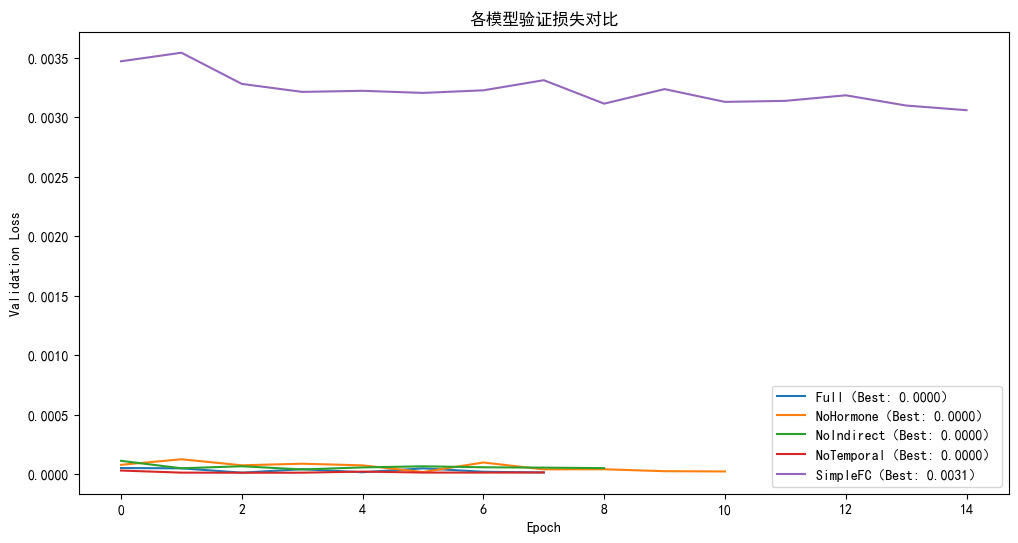

In [22]:
"""
本脚本用于批量训练 BrainInspiredNetV2 及其多个消融版本模型。
主要功能包括：
1. 多模型循环训练；
2. 日志自动记录（控制台 + 文件）；
3. 支持早停、学习率调度器；
4. 自动保存训练配置与可视化图像；
5. 记录所有模型的训练与验证过程。
"""

import os
import json
import time
import torch
import logging
import traceback
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from datetime import datetime
from torch.utils.data import DataLoader



# ==================== 模型名称与类的映射 ====================
model_dict = {
    "Full": BrainInspiredNetV2,                    # 完整模型
    "NoHormone": BrainInspiredNetV2_NoHormone,     # 去除激素调节模块
    "NoIndirect": BrainInspiredNetV2_NoIndirect,   # 去除间接连接（GAT）
    "NoTemporal": BrainInspiredNetV2_NoTemporal,   # 去除时间编码器
    "SimpleFC": BrainInspiredNetV2_SimpleFC        # 仅保留MLP结构
}

# ==================== 超参数配置 ====================
train_config = {
    "max_epochs": 15,              # 最大训练轮数
    "patience": 5,                 # 早停机制的耐心轮数
    "lr_scheduler_patience": 3,    # 学习率调度器的耐心轮数
    "lr_scheduler_factor": 0.5,    # 学习率下降因子
    "batch_size": 8,               # 每批样本数量
    "learning_rate": 1e-3          # 初始学习率
}

# ==================== 日志配置函数 ====================
def setup_logger(log_path=None, level=logging.INFO):
    """
    配置日志记录器，支持同时输出到控制台和文件。

    参数：
        log_path (str): 日志文件保存路径
        level (int): 日志级别，默认 INFO

    返回：
        logger (logging.Logger): 配置好的日志对象
    """
    logger_name = f"Logger_{datetime.now().strftime('%Y%m%d_%H%M%S_%f')}"
    logger = logging.getLogger(logger_name)
    logger.setLevel(level)
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

    # 控制台输出
    console_handler = logging.StreamHandler()
    console_handler.setLevel(level)
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)

    # 文件输出
    if log_path:
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        file_handler = logging.FileHandler(log_path)
        file_handler.setLevel(level)
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    return logger

# ==================== 训练过程可视化函数 ====================
def plot_training_curve(training_results, model_key, save_dir="figures"):
    """
    绘制训练与验证损失曲线，并保存为 PNG 图像。

    参数：
        training_results (dict): 包含训练与验证损失信息
        model_key (str): 当前模型名称
        save_dir (str): 图像保存文件夹
    """
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(12, 6))
    plt.plot(training_results['train_losses'], label='Train Loss')
    plt.plot(training_results['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'模型：{model_key} 的训练过程')
    plt.legend()
    plt.savefig(os.path.join(save_dir, f"training_curve_{model_key}.png"))
    plt.close()

# ==================== 初始化设备与路径 ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_base_path = "logs"
figure_path = "figures"
os.makedirs(log_base_path, exist_ok=True)
os.makedirs(figure_path, exist_ok=True)

# ==================== 加载数据（需要用户实现） ====================
train_loader, val_loader = create_data_loaders(X_train, y_train, batch_size=train_config["batch_size"])
# 请确保 X_train 已定义且符合维度要求

# ==================== 所有模型训练结果保存字典 ====================
all_training_results = {}

# ==================== 遍历每一个模型进行训练 ====================
for model_key in model_dict:
    try:
        # 创建模型日志记录器
        log_path = os.path.join(log_base_path, f"training_{model_key}.log")
        logger = setup_logger(log_path=log_path)

        logger.info(f"【开始训练】模型：{model_key}")

        # 构建模型实例并移动到设备
        model_class = model_dict[model_key]
        model = model_class(input_dim=X_train.shape[2]).to(device)

        # 优化器与损失函数
        optimizer = torch.optim.Adam(model.parameters(), lr=train_config["learning_rate"])
        criterion = nn.MSELoss()

        # 创建 Trainer 实例（Trainer 类需预先定义）
        trainer = Trainer(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            max_epochs=train_config["max_epochs"],
            patience=train_config["patience"],
            lr_scheduler_patience=train_config["lr_scheduler_patience"],
            lr_scheduler_factor=train_config["lr_scheduler_factor"],
            save_path=f"best_model_{model_key}.pth",
            log_path=log_path,
            custom_callbacks=[save_intermediate_model],  # 若无可删
            use_mask=False,
            save_state_dict=True
        )

        # 执行训练并计时
        start_time = time.time()
        training_results = trainer.train()
        duration = time.time() - start_time

        logger.info("✅ 训练完成")
        logger.info(f"⏱️ 总耗时：{duration:.2f} 秒")
        logger.info(f"🏆 最佳验证损失：{training_results['best_loss']:.6f}（第 {training_results['best_epoch']} 轮）")

        # 保存训练过程图像
        plot_training_curve(training_results, model_key, save_dir=figure_path)

        # 保存训练配置与结果
        config = {
            "model_name": model_key,
            "input_dim": X_train.shape[2],
            "device": str(device),
            "training_duration": duration,
            "best_epoch": training_results["best_epoch"],
            "best_loss": training_results["best_loss"],
            **train_config
        }
        with open(f"training_config_{model_key}.json", 'w') as f:
            json.dump(config, f, indent=4)

        # 保存损失信息
        all_training_results[model_key] = {
            "train_losses": training_results["train_losses"],
            "val_losses": training_results["val_losses"],
            "best_epoch": training_results["best_epoch"],
            "best_loss": training_results["best_loss"]
        }

        # 清理显存
        if device.type == "cuda":
            torch.cuda.empty_cache()

    except Exception as e:
        logger.error(f"❌ 模型 {model_key} 训练失败：\n{traceback.format_exc()}")

# ==================== 保存所有模型的训练结果汇总 ====================
with open("all_training_results.json", "w") as f:
    json.dump(all_training_results, f, indent=4)
print("✅ 所有训练结果已保存至 all_training_results.json")

# ==================== 绘制所有模型的验证损失对比图 ====================
plt.figure(figsize=(12, 6))
for model_key, result in all_training_results.items():
    plt.plot(result["val_losses"], label=f"{model_key}（Best: {result['best_loss']:.4f}）")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("各模型验证损失对比")
plt.legend()
plt.savefig(os.path.join(figure_path, "validation_loss_comparison.png"))
plt.show()


In [23]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader
# from datetime import datetime
# import logging
# import json
# import time
# import matplotlib.pyplot as plt
# import joblib
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import numpy as np


# # from your_model_file import BrainInspiredNetV2_Full, BrainInspiredNetV2_NoHormone, BrainInspiredNetV2_NoIndirect, BrainInspiredNetV2_NoTemporal, BrainInspiredNetV2_SimpleFC

# model_dict = {
#     "Full": BrainInspiredNetV2,  # 你现在的完整模型类
#     "NoHormone": BrainInspiredNetV2_NoHormone,
#     "NoIndirect": BrainInspiredNetV2_NoIndirect,
#     "NoTemporal": BrainInspiredNetV2_NoTemporal,
#     "SimpleFC": BrainInspiredNetV2_SimpleFC,
# }

# # 设置日志路径
# log_path = "training.log"
# logger = setup_logger(log_path=log_path)

# # 检查设备
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# # 你可以通过修改这里的 key 来选择消融模型
# selected_model_key = "NoHormone"  # 比如改成 "Full", "NoIndirect" 等






# # 1. 实例化模型
# model_class = model_dict[selected_model_key]
# model = model_class(input_dim=X_train.shape[2]).to(device)

# # 2. 定义优化器
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # 3. 定义损失函数
# criterion = nn.MSELoss()

# # 4. 定义 Trainer 实例
# trainer = Trainer(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     optimizer=optimizer,
#     criterion=criterion,
#     device=device,
#     max_epochs=15,
#     patience=5,
#     lr_scheduler_patience=3,
#     lr_scheduler_factor=0.5,
#     save_path="best_model.pth",
#     log_path=log_path,
#     custom_callbacks=[save_intermediate_model],
#     use_mask=False,
#     save_state_dict=True
# )

# # 5. 开始训练
# start_time = time.time()  # 记录训练开始时间
# training_results = trainer.train()
# end_time = time.time()  # 记录训练结束时间
# training_duration = end_time - start_time  # 计算训练总耗时

# # 6. 打印训练结果
# logger.info(f"Starting training for model: {selected_model_key}")
# start_time = time.time()
# training_results = trainer.train()
# end_time = time.time()
# training_duration = end_time - start_time
# logger.info("Training completed.")
# logger.info(f"Training duration: {training_duration / 60:.2f} minutes")
# logger.info(f"Train losses: {training_results['train_losses']}")
# logger.info(f"Validation losses: {training_results['val_losses']}")
# logger.info(f"Best epoch: {training_results['best_epoch']}")
# logger.info(f"Best validation loss: {training_results['best_loss']}")


# # 7. 绘制训练曲线
# plt.figure(figsize=(12, 6))
# plt.plot(training_results['train_losses'], label='Train Loss')
# plt.plot(training_results['val_losses'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title(f'Training and Validation Losses - Model: {selected_model_key}')
# plt.legend()
# plt.savefig(f'training_curve_{selected_model_key}.png')  # 每个模型保存不同图
# plt.show()

# # 8. 自动保存运行配置
# # 创建一个字典来保存训练过程中的关键配置和结果
# config = {
#     "model_name": selected_model_key,  # 记录当前消融版本名字
#     "input_dim": X_train.shape[2],  # 输入维度
#     "max_epochs": 15,  # 最大训练轮数
#     "patience": 5,  # 早停机制的耐心值
#     "lr_scheduler_patience": 3,  # 学习率调度器的耐心值
#     "lr_scheduler_factor": 0.5,  # 学习率调度器的衰减因子
#     "batch_size": 8,  # 训练数据的批次大小
#     "learning_rate": optimizer.param_groups[0]['lr'],  # 初始学习率
#     "device": str(device),  # 训练使用的设备（CPU 或 GPU）
#     "training_duration": training_duration,  # 训练总耗时（秒）
#     "best_epoch": training_results['best_epoch'],  # 最佳训练轮次
#     "best_loss": training_results['best_loss'],  # 最佳验证损失
#     "save_path": "best_model.pth",  # 最佳模型保存路径
#     "log_path": log_path  # 日志文件路径
# }

# # 定义保存配置文件的路径
# config_path = "training_config.json"

# # 将配置字典保存为 JSON 文件
# with open(config_path, 'w') as f:
#     json.dump(config, f, indent=4)  # 使用缩进格式化 JSON 文件

# # 记录到日志
# logger.info(f"Training configuration saved to {config_path}")

In [24]:
# 将模型设置为评估模式
model.eval()

# 初始化预测值和真实值的列表
preds, actuals = [], []

# 禁用梯度计算（推理阶段不需要计算梯度，节省计算资源和内存）
with torch.no_grad():
    # 遍历验证数据加载器中的每个批次
    for x_batch, y_batch in val_loader:
        # 将输入数据移动到指定设备（CPU或GPU）
        x_batch = x_batch.to(device)
        # 前向传播，获取预测结果（忽略激素状态）
        pred, _ = model(x_batch)
        # 将预测结果从张量转换为 NumPy 数组，并添加到预测值列表中
        preds.extend(pred.cpu().numpy())
        # 将真实值从张量转换为 NumPy 数组，并添加到真实值列表中
        actuals.extend(y_batch.numpy())

# 绘制真实值和预测值的对比图
plt.plot(actuals, label="True")  # 绘制真实值曲线，标签为 "True"
plt.plot(preds, label="Predicted")  # 绘制预测值曲线，标签为 "Predicted"
plt.legend()  # 显示图例
plt.title("Prediction on Validation Set")  # 设置图表标题
plt.show()  # 显示图表

ValueError: too many values to unpack (expected 2)

In [ ]:
# 导入 sklearn.metrics 中的 mean_squared_error 函数
from sklearn.metrics import mean_squared_error

# 计算均方误差（MSE）
mse = mean_squared_error(actuals, preds)  # 使用 actuals 和 preds 计算 MSE
print(f"Mean Squared Error (MSE): {mse:.4f}")  # 打印 MSE，保留 4 位小数

# 导入 numpy 库
import numpy as np

# 计算均方根误差（RMSE）
rmse = np.sqrt(mse)  # 对 MSE 取平方根得到 RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # 打印 RMSE，保留 4 位小数

# 导入 sklearn.metrics 中的 r2_score 函数
from sklearn.metrics import r2_score

# 计算决定系数（R² Score）
r2 = r2_score(actuals, preds)  # 使用 actuals 和 preds 计算 R² Score
print(f"R² Score: {r2:.4f}")  # 打印 R² Score，保留 4 位小数

In [ ]:
import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ========== 设备设置 ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 1. 加载模型结构 ==========
# 从验证集中获取输入维度
sample_input, _ = next(iter(val_loader))
input_dim = sample_input.shape[2]  # [batch, seq_len, input_dim]
model = BrainInspiredNetV2(input_dim=input_dim).to(device)

# ========== 2. 加载模型参数 ==========
model.load_state_dict(torch.load("best_model_20250605_195543.pth", map_location=device))
model.eval()

# ========== 3. 加载目标变量归一化器 ==========
y_scaler = joblib.load("y_scaler.pkl")

# ========== 4. 定义反归一化函数 ==========
def inverse_transform_target(scaler, data):
    """
    将归一化后的数据进行反归一化恢复真实值
    """
    if isinstance(data, torch.Tensor):
        data = data.detach().cpu().numpy()
    data = data.reshape(-1, 1)
    return scaler.inverse_transform(data).flatten()

# ========== 5. 验证模型并收集输出 ==========
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # 如果模型输出是多个值，只取第一个作为预测值

        all_preds.append(outputs.cpu())
        all_targets.append(targets.cpu())

# 合并所有批次预测值和真实值
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# ========== 6. 反归一化 ==========
y_pred_inv = inverse_transform_target(y_scaler, all_preds)
y_true_inv = inverse_transform_target(y_scaler, all_targets)

# ========== 7. 评估指标 ==========
rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
mae = mean_absolute_error(y_true_inv, y_pred_inv)
r2 = r2_score(y_true_inv, y_pred_inv)

print("【反归一化后验证集评估】")
print(f"RMSE: {rmse:.4f} °C")
print(f"MAE : {mae:.4f} °C")
print(f"R²  : {r2:.4f}")

# ========== 8. 可视化预测效果 ==========
plt.figure(figsize=(12, 5))
plot_len = 20000  # 可视化前若干样本，避免图太长
plt.plot(y_true_inv[:plot_len], label="真实值", linewidth=1)
plt.plot(y_pred_inv[:plot_len], label="预测值", linewidth=1)
plt.title("真实值 vs 预测值（前 20000 个样本）")
plt.xlabel("样本索引")
plt.ylabel("温度 (°C)")
plt.legend()
plt.tight_layout()
plt.savefig("prediction_vs_true.png")
plt.show()
